# Molecular Similarity Search and Clustering using AI

This project performs molecular similarity search and clustering using Morgan fingerprints, Tanimoto similarity, FAISS, KMeans, UMAP, and Butina clustering.

#Install Libraries

## Step 1: Import Required Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
!pip install rdkit
!pip install faiss-cpu # Install faiss-cpu
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, DataStructs, rdMolDescriptors # Added rdMolDescriptors
from rdkit.ML.Cluster import Butina
import matplotlib.pyplot as plt
import umap
import faiss

## Step 2: Load Dataset

In [ ]:
CSV_PATH = "molecules.csv"
df = pd.read_csv(CSV_PATH)
df = df.dropna(subset=["SMILES"]).reset_index(drop=True)

In [ ]:
df

,ID,SMILES
0,89594,CN1CCC[C@H]1C2=CN=CC=C2
1,2160,CN(C)CCC=C1C2=CC=CC=C2CCC3=CC=CC=C31
2,1615,CC(CC1=CC2=C(C=C1)OCO2)NC
3,135398737,CN1CCN(CC1)C2=NC3=C(C=CC(=C3)Cl)NC4=CC=CC=C42
4,2391,CC(=O)OC1=CC=C(C=C1)C(C2=CC=C(C=C2)OC(=O)C)C3=...
...,...,...
1454,5702260,C[C@@H]1CC(=O)[C@]2([C@@H](O1)OC3[C@H]([C@@H](...
1455,5702292,CN1CC[C@]23[C@@H]4[C@@H](C=CC2[C@H]1CC5=C3C(=C...
1456,5701995,CC[C@@H]1[C@H](COC1=O)CC2=CC=CN2C
1457,5702230,C1[C@@H]([C@H]([C@@H]([C@@H]([C@H]1O)N)O[C@H]2...


## Step 3: Sanitize SMILES & Compute descriptors

In [ ]:
# compute descriptors
def sanitize_and_describe(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None, None, None, None, None
    can_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    hba = Descriptors.NumHAcceptors(mol)
    hbd = Descriptors.NumHDonors(mol)
    return can_smiles, mw, logp, tpsa, hba, hbd

df[['SMILES', 'MW', 'LogP', 'TPSA', 'HBA', 'HBD']] = df['SMILES'].apply(
    lambda x: pd.Series(sanitize_and_describe(x))
)
df = df.dropna(subset=['SMILES']).reset_index(drop=True)

In [ ]:
df.head()

,ID,SMILES,MW,LogP,TPSA,HBA,HBD
0,89594,CN1CCC[C@H]1c1cccnc1,162.236,1.8483,16.13,2,0
1,2160,CN(C)CCC=C1c2ccccc2CCc2ccccc21,277.411,4.1686,3.24,1,0
2,1615,CNC(C)Cc1ccc2c(c1)OCO2,193.246,1.5657,30.49,3,1
3,135398737,CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1,326.831,3.7227,30.87,4,1
4,2391,CC(=O)Oc1ccc(C(c2ccc(OC(C)=O)cc2)c2ccccn2)cc1,361.397,4.1124,65.49,5,0


In [ ]:
if 'ID' in df.columns:
    df = df.drop(columns=['ID'])

In [ ]:
df

,SMILES,MW,LogP,TPSA,HBA,HBD
0,CN1CCC[C@H]1c1cccnc1,162.236,1.8483,16.13,2,0
1,CN(C)CCC=C1c2ccccc2CCc2ccccc21,277.411,4.1686,3.24,1,0
2,CNC(C)Cc1ccc2c(c1)OCO2,193.246,1.5657,30.49,3,1
3,CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1,326.831,3.7227,30.87,4,1
4,CC(=O)Oc1ccc(C(c2ccc(OC(C)=O)cc2)c2ccccn2)cc1,361.397,4.1124,65.49,5,0
...,...,...,...,...,...,...
1454,CN[C@@H]1[C@H](O)[C@H](NC)[C@H]2O[C@@]3(O)C(=O...,332.353,-2.9256,129.51,9,5
1455,CN1CC[C@]23c4c5ccc(O)c4O[C@H]2[C@H](O)C=CC3[C@...,285.343,1.1981,52.93,4,2
1456,CC[C@H]1C(=O)OC[C@@H]1Cc1cccn1C,207.273,1.7668,31.23,3,0
1457,NC[C@@H]1O[C@H](OC2[C@@H](O)[C@H](O[C@@H]3[C@H...,615.634,-8.8617,347.32,19,13


## Step 4: Generate Morgan Fingerprints

In [ ]:
def morgan_fp(smiles, nBits=1024, radius=2):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros((nBits,), dtype=np.uint8)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    arr = np.zeros((nBits,), dtype=np.uint8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

fps = np.vstack([morgan_fp(s) for s in df.SMILES]).astype("float32")

[06:03:55] DEPRECATION WARNING: please use MorganGenerator
[06:03:55] DEPRECATION WARNING: please use MorganGenerator
[06:03:55] DEPRECATION WARNING: please use MorganGenerator
[06:03:55] DEPRECATION WARNING: please use MorganGenerator
[06:03:55] DEPRECATION WARNING: please use MorganGenerator
[06:03:55] DEPRECATION WARNING: please use MorganGenerator
[06:03:55] DEPRECATION WARNING: please use MorganGenerator
[06:03:55] DEPRECATION WARNING: please use MorganGenerator
[06:03:55] DEPRECATION WARNING: please use MorganGenerator
[06:03:55] DEPRECATION WARNING: please use MorganGenerator
[06:03:55] DEPRECATION WARNING: please use MorganGenerator
[06:03:55] DEPRECATION WARNING: please use MorganGenerator
[06:03:55] DEPRECATION WARNING: please use MorganGenerator
[06:03:55] DEPRECATION WARNING: please use MorganGenerator
[06:03:55] DEPRECATION WARNING: please use MorganGenerator
[06:03:55] DEPRECATION WARNING: please use MorganGenerator
[06:03:55] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
# RDKit ExplicitBitVect
bitvects = [DataStructs.ExplicitBitVect(len(f)) for f in fps]
for i, f in enumerate(fps):
    bv = bitvects[i]
    for j, bit in enumerate(f):
        if bit: bv.SetBit(j)

In [ ]:
df

,SMILES,MW,LogP,TPSA,HBA,HBD
0,CN1CCC[C@H]1c1cccnc1,162.236,1.8483,16.13,2,0
1,CN(C)CCC=C1c2ccccc2CCc2ccccc21,277.411,4.1686,3.24,1,0
2,CNC(C)Cc1ccc2c(c1)OCO2,193.246,1.5657,30.49,3,1
3,CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1,326.831,3.7227,30.87,4,1
4,CC(=O)Oc1ccc(C(c2ccc(OC(C)=O)cc2)c2ccccn2)cc1,361.397,4.1124,65.49,5,0
...,...,...,...,...,...,...
1454,CN[C@@H]1[C@H](O)[C@H](NC)[C@H]2O[C@@]3(O)C(=O...,332.353,-2.9256,129.51,9,5
1455,CN1CC[C@]23c4c5ccc(O)c4O[C@H]2[C@H](O)C=CC3[C@...,285.343,1.1981,52.93,4,2
1456,CC[C@H]1C(=O)OC[C@@H]1Cc1cccn1C,207.273,1.7668,31.23,3,0
1457,NC[C@@H]1O[C@H](OC2[C@@H](O)[C@H](O[C@@H]3[C@H...,615.634,-8.8617,347.32,19,13


In [ ]:
fp_df = pd.DataFrame(fps)
fp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step 5: Top Tanimoto Similarity Search

In [ ]:
def topk_tanimoto(idx, k=5):
    q = bitvects[idx]
    sims = DataStructs.BulkTanimotoSimilarity(q, bitvects)
    sims = np.array(sims)
    order = np.argsort(-sims)
    hits = [i for i in order if i != idx][:k]
    return hits, sims[hits]

## Step 6: Similarity Distance Calculation and Butina Clustering

In [ ]:
n_fps = len(fps)
dists = []
for i in range(1, n_fps):
    sims = DataStructs.BulkTanimotoSimilarity(bitvects[i], bitvects[:i])
    dists.extend([1 - s for s in sims])

SIM_CUTOFF = 0.7
clusters = Butina.ClusterData(dists, n_fps, 1 - SIM_CUTOFF, isDistData=True)

cluster_labels = np.zeros(n_fps, dtype=int)
for cluster_id, cluster in enumerate(clusters):
    for idx in cluster:
        cluster_labels[idx] = cluster_id
df['cluster'] = cluster_labels

## Step 7: UMAP Visualization of Molecular Space

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


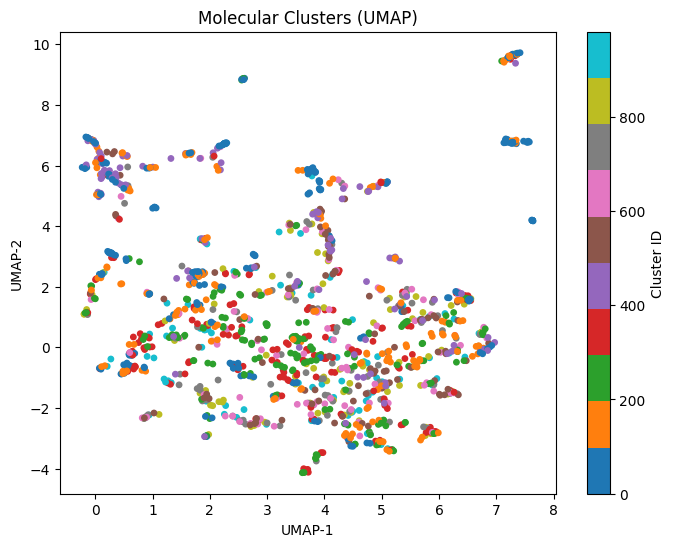

In [ ]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='jaccard', random_state=42)
X2D = reducer.fit_transform(fps)
df['x_umap'] = X2D[:,0]
df['y_umap'] = X2D[:,1]

plt.figure(figsize=(8,6))
plt.scatter(df['x_umap'], df['y_umap'], c=df['cluster'], cmap="tab10", s=15)
plt.title("Molecular Clusters (UMAP)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label='Cluster ID')
plt.savefig("umap_clusters.png", dpi=300)
plt.show()

## Step 8: fast Similarity(Optional)

In [ ]:
index = faiss.IndexFlatL2(fps.shape[1])
index.add(fps)

def faiss_search(idx, k=5):
    q = fps[idx].reshape(1, -1)
    D, I = index.search(q, k+1)
    return I[0][1:], D[0][1:]

## Step 9: Results

In [ ]:
df.to_csv("processed_molecules_with_umap.csv", index=False)

topk_list = []
for i in range(len(df)):
    hits, sims = topk_tanimoto(i)
    topk_list.append((i, hits, sims.tolist()))
topk_df = pd.DataFrame(topk_list, columns=['index', 'top5_indices', 'top5_tanimoto'])
topk_df.to_csv("similarity_topk.csv", index=False)

In [ ]:
cluster_ids = [-1] * len(fps)

for cid, cluster in enumerate(clusters):
    for mol_idx in cluster:
        cluster_ids[mol_idx] = cid

df["Cluster_ID"] = cluster_ids
df.to_csv("molecules_butina_clusters.csv", index=False)

In [ ]:
sim = DataStructs.TanimotoSimilarity(bitvects[0], bitvects[1])
print("Tanimoto similarity:", sim)

Tanimoto similarity: 0.11538461538461539


In [ ]:
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs
import numpy as np



dists = []
nfps = len(bitvects)

for i in range(1, nfps):
    sims = DataStructs.BulkTanimotoSimilarity(bitvects[i], bitvects[:i])
    dists.extend([1 - x for x in sims])

threshold = 0.4
clusters = Butina.ClusterData(dists, nfps, threshold, isDistData=True)

for i, c in enumerate(clusters):
    print("Cluster", i, ":", list(c))

cluster_id = np.zeros(nfps, dtype=int)

for i, c in enumerate(clusters):
    for mol_idx in c:
        cluster_id[mol_idx] = i

df["Cluster"] = cluster_id
df.to_csv("butina_clusters_output.csv", index=False)

Cluster 0 : [1400, 286, 792, 1283, 1304, 1366, 1380, 1404, 1441, 1443, 1444, 1449, 1457, 1458]
Cluster 1 : [745, 236, 598, 692, 760, 763, 1071, 1234, 1249, 1314, 1349, 1361, 1408, 1445]
Cluster 2 : [1387, 887, 1143, 1148, 1206, 1208, 1237, 1243, 1299, 1317, 1396]
Cluster 3 : [139, 84, 142, 843, 1233, 1246, 1264, 1286, 1343, 1386, 1406]
Cluster 4 : [288, 511, 567, 751, 848, 1451]
Cluster 5 : [136, 11, 13, 58, 66, 79, 101, 108, 129]
Cluster 6 : [1372, 270, 810, 884, 915, 1047, 1088, 1180]
Cluster 7 : [1298, 247, 345, 643, 691, 694, 773, 1076]
Cluster 8 : [1075, 1203, 1212, 1250, 1251, 1359, 1412, 1447]
Cluster 9 : [837, 493, 545, 725, 800, 835, 855, 878]
Cluster 10 : [765, 429, 629, 690, 821, 856]
Cluster 11 : [1313, 300, 378, 746, 838, 1034, 1273]
Cluster 12 : [1252, 1260]
Cluster 13 : [1140, 1154, 1242, 1245, 1256, 1352, 1371]
Cluster 14 : [351, 127, 424, 474, 744, 770, 1254]
Cluster 15 : [1, 5, 23, 92, 96, 138, 143]
Cluster 16 : [1453, 1355, 1430]
Cluster 17 : [1397]
Cluster 18 : [126

## Results Explanation

- Tanimoto similarity values show molecular similarity.
- A value around 0.115 means molecules are structurally different.
- Butina clustering grouped molecules based on 0.4 distance threshold.
- Many single clusters indicate structural diversity in the dataset.\